# Proyecto final 

## Importar bibliotecas necesarias

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

## Cargar y explorar los datos

In [2]:
data_path = "/datasets/final_provider/"

# Cargar archivos
contract = pd.read_csv(os.path.join(data_path, "contract.csv"))
personal = pd.read_csv(os.path.join(data_path, "personal.csv"))
internet = pd.read_csv(os.path.join(data_path, "internet.csv"))
phone = pd.read_csv(os.path.join(data_path, "phone.csv"))

# Inspección inicial
print("Contract Data:")
print(contract.head(), "\n")

Contract Data:
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65   



In [3]:
print("Personal Data:")
print(personal.head(), "\n")

Personal Data:
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No 



In [4]:
print("Internet Data:")
print(internet.head(), "\n")

Internet Data:
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No   



In [5]:
print("Phone Data:")
print(phone.head(), "\n")

Phone Data:
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes 



In [6]:
# Combinar datasets usando customerID
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')

# Verificar datos combinados
print("Datos combinados:")
print(df.head())
print(df.info())

Datos combinados:
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

   gender  SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0  Female              0     Yes      

## limpieza de datos

In [7]:
# Manejo de la columna TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convierte a numérico, NaN si hay errores

# Verificar valores faltantes
print("Valores faltantes por columna:")
print(df.isnull().sum())

# Manejo de valores nulos
# Llenar valores faltantes de InternetService con 'No'
df['InternetService'].fillna('No', inplace=True)

# Llenar valores faltantes en columnas de servicios de Internet con 'No'
internet_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
df[internet_columns] = df[internet_columns].fillna('No')

# Llenar valores faltantes en MultipleLines con 'No'
df['MultipleLines'].fillna('No', inplace=True)

# Llenar valores faltantes en TotalCharges con la mediana
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Convertir datos categóricos a variables numéricas
categorical_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 
                       'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                       'StreamingTV', 'StreamingMovies', 'MultipleLines']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Verificar la limpieza
print("Datos después de la limpieza:")
print(df.info())

Valores faltantes por columna:
customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64
Datos después de la limpieza:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   BeginDate                              7043 non-null   object 
 2   EndDate                                704

In [8]:
# Convertir TotalCharges a numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Crear variable objetivo (cancelación: 1 si EndDate != 'No', 0 en caso contrario)
df['Churn'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

# Verificar valores faltantes
print("Valores faltantes por columna:")
print(df.isnull().sum())

# Llenar valores faltantes
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df.fillna('No', inplace=True)

Valores faltantes por columna:
customerID                               0
BeginDate                                0
EndDate                                  0
MonthlyCharges                           0
TotalCharges                             0
SeniorCitizen                            0
Type_One year                            0
Type_Two year                            0
PaperlessBilling_Yes                     0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
gender_Male                              0
Partner_Yes                              0
Dependents_Yes                           0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_Yes                       0
OnlineBackup_Yes                         0
DeviceProtection_Yes                     0
TechSupport_Yes                          0
StreamingTV_Yes                          0
StreamingMovies_Yes    

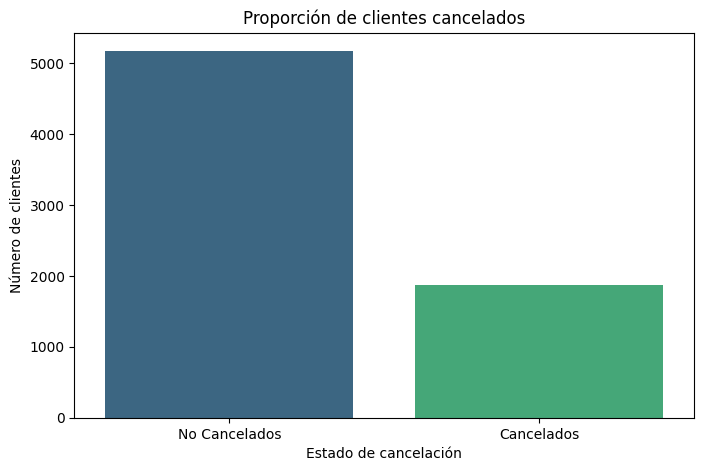

In [9]:
### 1. Proporción de clientes cancelados
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=df, palette="viridis")
plt.title("Proporción de clientes cancelados")
plt.xticks([0, 1], ['No Cancelados', 'Cancelados'])
plt.xlabel("Estado de cancelación")
plt.ylabel("Número de clientes")
plt.show()

Dado que la mayoría de los clientes no cancelaron su contrato, la variable objetivo está desequilibrada. Esto podría afectar el desempeño de los modelos predictivos, especialmente si no se toman medidas como el balanceo de clases.

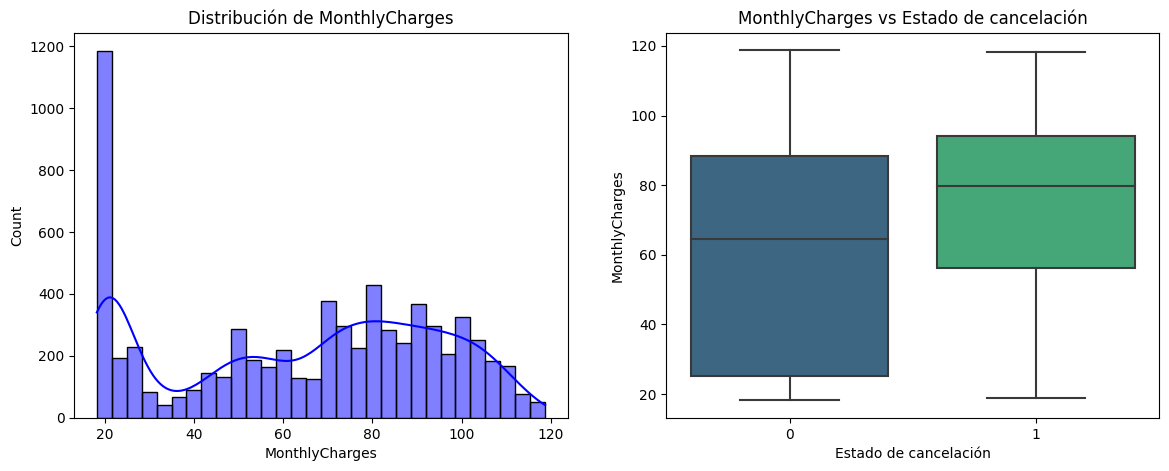

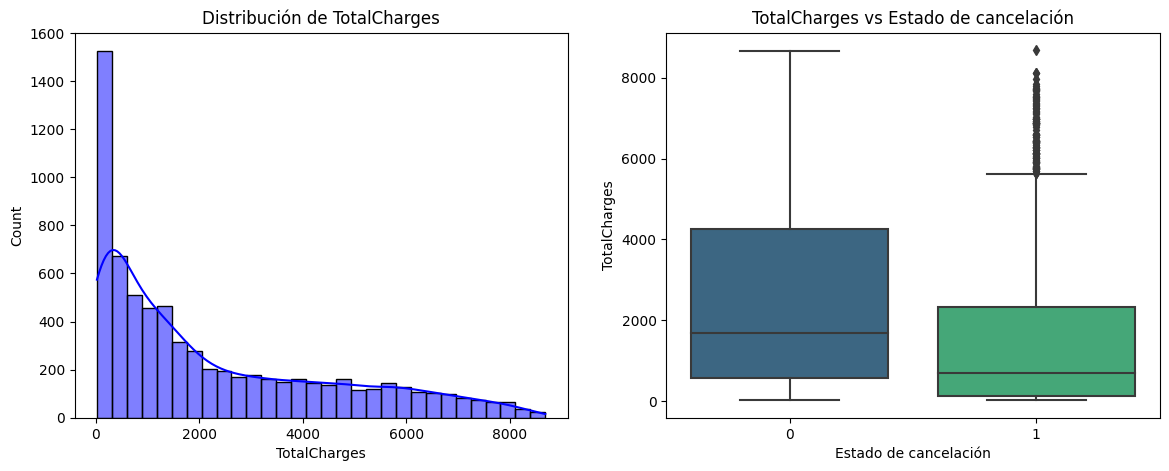

In [10]:
### 2. Distribución de MonthlyCharges y TotalCharges
for col in ['MonthlyCharges', 'TotalCharges']:
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, y=col, x="Churn", palette="viridis")
    plt.title(f"{col} vs Estado de cancelación")
    plt.xlabel("Estado de cancelación")
    plt.ylabel(col)
    plt.show()

Estas gráficas destacan posibles patrones en los cargos mensuales y totales. MonthlyCharges más altos parecen estar relacionados con una mayor probabilidad de cancelación, mientras que los clientes de larga duración (TotalCharges altos) tienen menos probabilidad de cancelar. Esto sugiere que las estrategias de retención deben enfocarse especialmente en clientes con tarifas mensuales altas y en los primeros meses de su relación con la empresa.

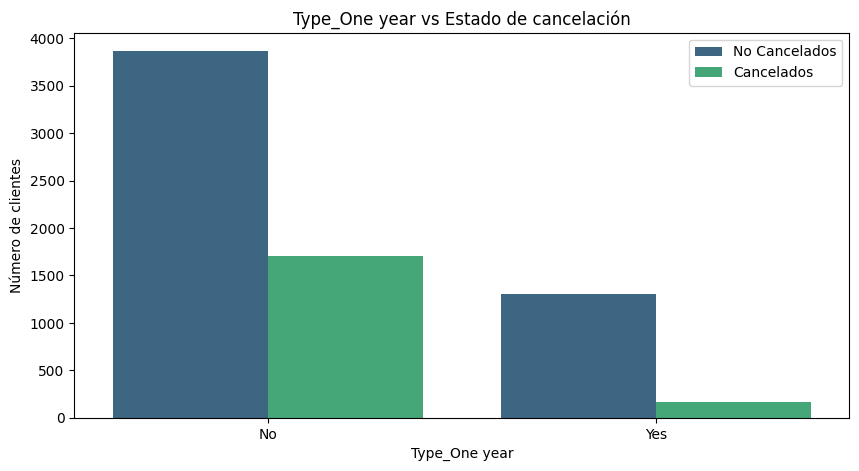

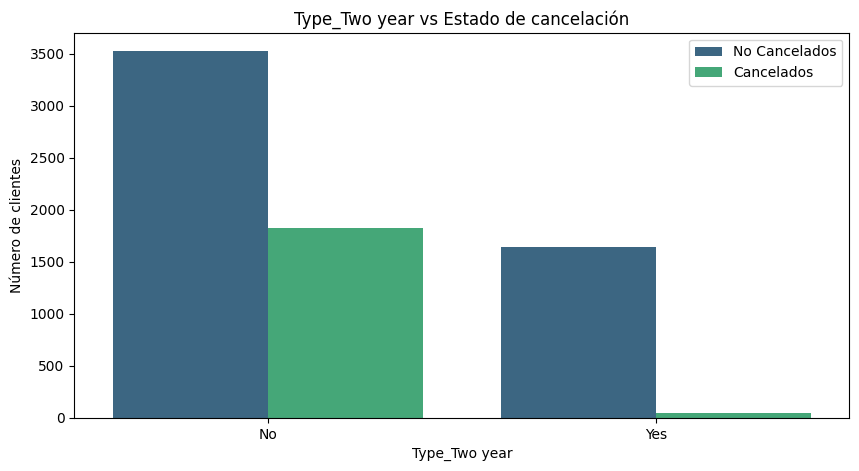

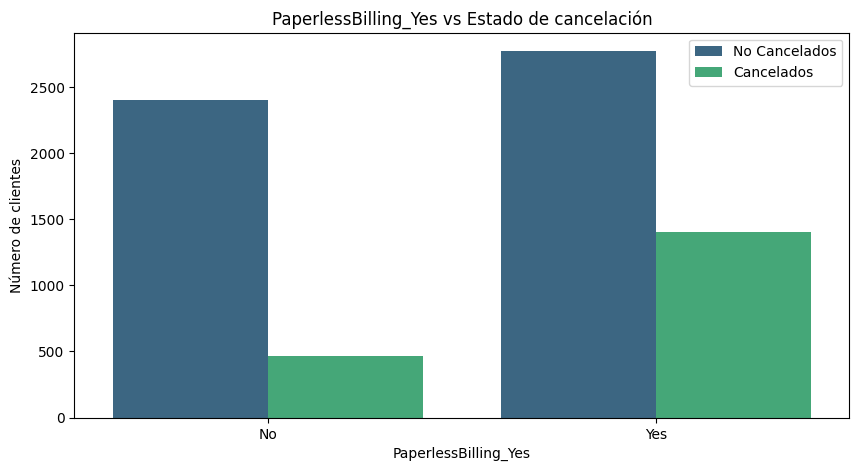

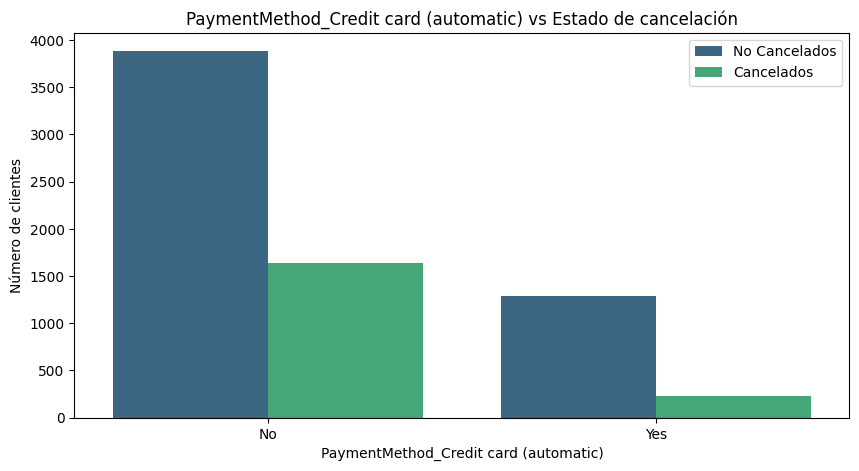

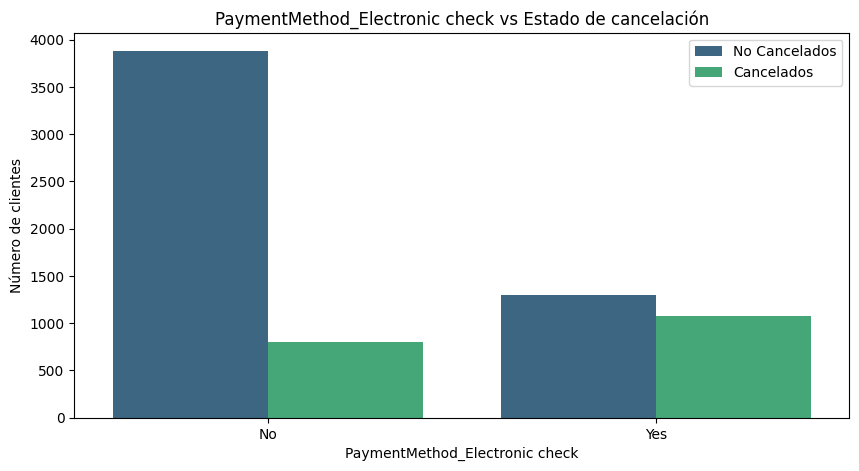

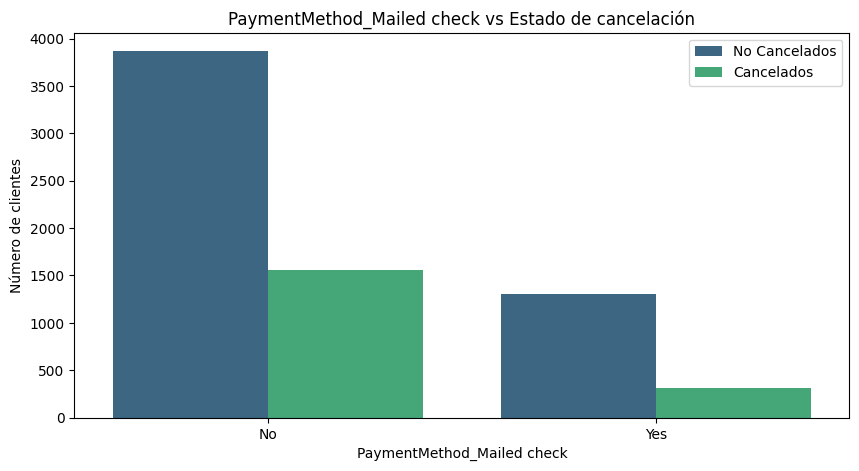

In [11]:
### 3. Relación de variables categóricas con cancelación
binary_cols = [
    'Type_One year', 'Type_Two year', 
    'PaperlessBilling_Yes', 
    'PaymentMethod_Credit card (automatic)', 
    'PaymentMethod_Electronic check', 
    'PaymentMethod_Mailed check'
]

for col in binary_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col, hue='Churn', palette="viridis")
    plt.title(f"{col} vs Estado de cancelación")
    plt.xlabel(col)
    plt.ylabel("Número de clientes")
    plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
    plt.legend(['No Cancelados', 'Cancelados'])
    plt.show()

- Los contratos de un año parecen estar asociados con una menor probabilidad de cancelación. Esto podría deberse a compromisos contractuales que desincentivan la cancelación.
- Los contratos de dos años parecen estar asociados con una menor probabilidad de cancelación. Esto podría deberse a compromisos contractuales que desincentivan la cancelación.
- Los clientes que usan facturación sin papel parecen más propensos a cancelar. Esto podría deberse a factores demográficos (como ser más jóvenes o estar más habituados a comparar opciones en línea).
- Los clientes que efectúan sus pagos en automatico no son tan propensos a cancelación. Esto puede deberse a la comodidad de uso.
- Los clientes que efectuan sus pagos cheuqes electronicos tienen tendecia notable a cancelación. Esto puede deberse a que no quedan satisfechos con este metodo de pago.
- Los clientes que usan cheques enviados por correo no tienen tendecia de cancelación. Esto puede deberse a la facilidad y/o comodidad que ienen con este metodo de pago.

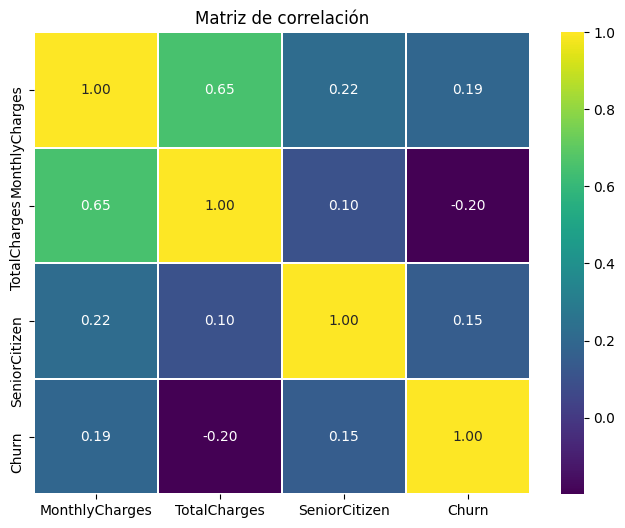

In [12]:
### 4. Matriz de correlación
numerical_cols = ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Churn']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación")
plt.show()

podemos observar loa siguiente:

- Monthly Charges tiene una correlación positiva con Total Charges de 0.65
- Total Charges y senior citizen tienen una debil correlación positiva de 0.1
- senior citizen y Churn tienen una debil correlacion positiva de 0.15
- Total Charges y churn tienen una debil correlación negativa de -0.2
- Monthly Charges y senior citizen tienen una correlación positiva de 0.22
- Monthly Charges y Churn tienen una debil correlación positiva de 0.19

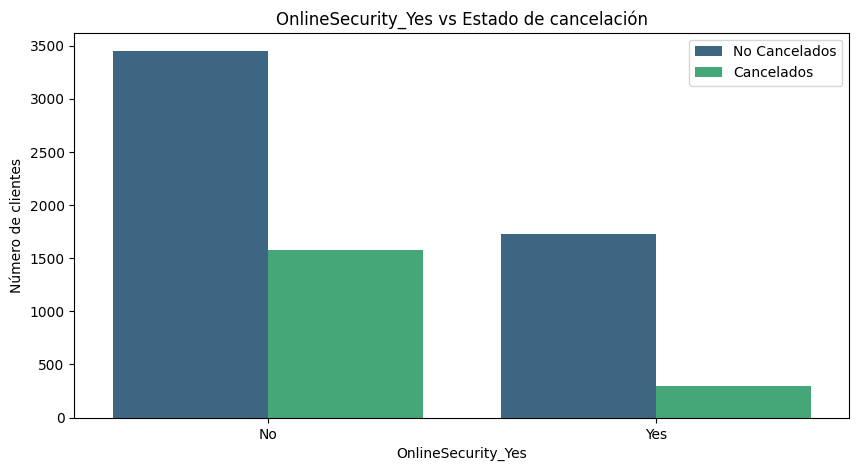

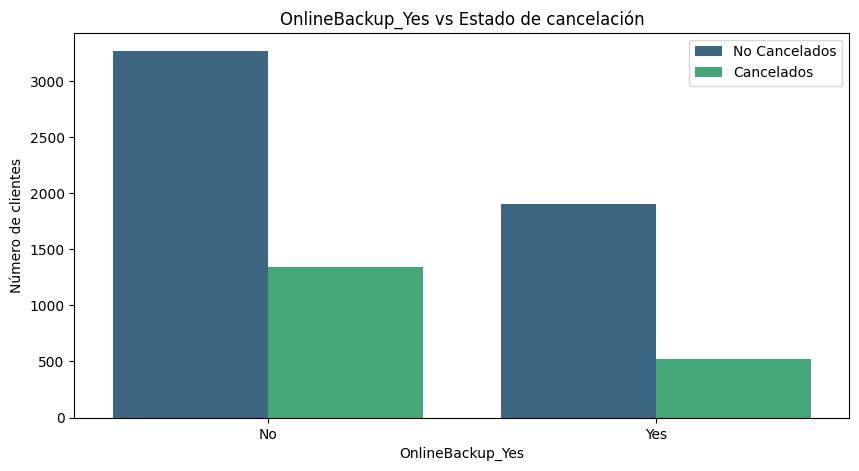

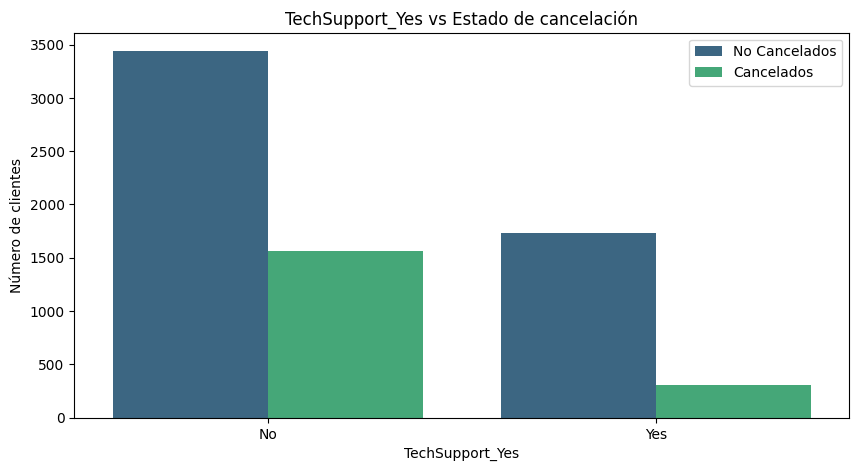

In [13]:
### 5. Impacto de los servicios contratados
internet_services = [
    'OnlineSecurity_Yes', 
    'OnlineBackup_Yes', 
    'TechSupport_Yes']

for service in internet_services:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=service, hue='Churn', palette="viridis")
    plt.title(f"{service} vs Estado de cancelación")
    plt.xlabel(service)
    plt.ylabel("Número de clientes")
    plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
    plt.legend(['No Cancelados', 'Cancelados'])
    plt.show()


En general, los clientes que no cuentan con estos servicios de ciberseguridad, respaldo en linea y soporte tecnico parecen a estar asociados a una mayo tasa de cancelación pero comparado con los clientes que si cuentan con estos servicios es proporcional a los que no. Esto puede sugerir que estos servicios no son causa de cancelación. 

## division de datos

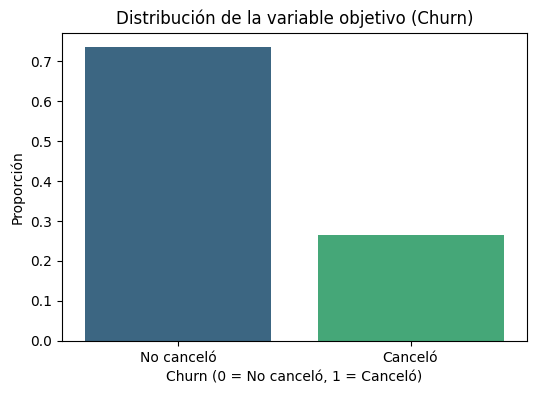

Proporción de clientes que no cancelaron: 73.46%
Proporción de clientes que cancelaron: 26.54%


In [14]:
# Análisis del balance de la variable objetivo
churn_counts = df['Churn'].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")
plt.title("Distribución de la variable objetivo (Churn)")
plt.xlabel("Churn (0 = No canceló, 1 = Canceló)")
plt.ylabel("Proporción")
plt.xticks([0, 1], ['No canceló', 'Canceló'])
plt.show()

# Imprimir proporciones
print("Proporción de clientes que no cancelaron: {:.2f}%".format(churn_counts[0] * 100))
print("Proporción de clientes que cancelaron: {:.2f}%".format(churn_counts[1] * 100))

In [15]:
# Separar las clases mayoritaria y minoritaria
class_majority = df[df['Churn'] == 0]
class_minority = df[df['Churn'] == 1]

# Calcular cuántas filas duplicar para igualar las clases
n_samples_majority = len(class_majority)
class_minority_oversampled = class_minority.sample(n=n_samples_majority, replace=True, random_state=42)

# Combinar las dos clases
df_balanced = pd.concat([class_majority, class_minority_oversampled], axis=0)

# Mezclar las filas
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el balance
print(df_balanced['Churn'].value_counts(normalize=True))


0    0.5
1    0.5
Name: Churn, dtype: float64


In [16]:
# Dividir los datos nuevamente después del balanceo
X = df_balanced.drop(['customerID', 'BeginDate', 'EndDate', 'Churn'], axis=1)  # Ajusta las columnas no útiles
y = df_balanced['Churn']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Datos balanceados y preparados para el modelado.")


Datos balanceados y preparados para el modelado.


## Entrenamiento del modelo

In [17]:
# Modelo 1: Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Evaluación del modelo Logistic Regression
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]):.4f}")

# Modelo 2: Random Forest
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Evaluación del modelo Random Forest
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1]):.4f}")

# Comparación de modelos
scores_lr = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1')
scores_rf = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='f1')
print("\nCross-Validation F1 Scores:")
print(f"Logistic Regression: {scores_lr.mean():.4f}")
print(f"Random Forest: {scores_rf.mean():.4f}")


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1021
           1       0.74      0.80      0.77      1049

    accuracy                           0.75      2070
   macro avg       0.76      0.75      0.75      2070
weighted avg       0.76      0.75      0.75      2070

Accuracy: 0.7541
ROC AUC: 0.8333
Random Forest Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.89      1021
           1       0.86      0.96      0.91      1049

    accuracy                           0.90      2070
   macro avg       0.91      0.90      0.90      2070
weighted avg       0.91      0.90      0.90      2070

Accuracy: 0.9019
ROC AUC: 0.9696

Cross-Validation F1 Scores:
Logistic Regression: 0.7596
Random Forest: 0.8962


Random Forest parece ser el mejor modelo en este caso debido a su capacidad para identificar correctamente tanto a los clientes que no cancelan (Clase 0) como a los que cancelan (Clase 1), con un desempeño consistente y alto en todas las métricas.

In [18]:
# Crear y entrenar el modelo
lgb_clf = lgb.LGBMClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
lgb_clf.fit(X_train, y_train)

# Predicciones
y_pred_lgb = lgb_clf.predict(X_test)
y_pred_lgb_proba = lgb_clf.predict_proba(X_test)[:, 1]

# Evaluación
print("LightGBM Report:")
print(classification_report(y_test, y_pred_lgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_lgb_proba):.4f}")

# Cross-Validation F1 Score
lgb_cv_scores = cross_val_score(lgb_clf, X_train, y_train, cv=5, scoring='f1')
print(f"LightGBM Cross-Validation F1 Score: {lgb_cv_scores.mean():.4f}")

LightGBM Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82      1021
           1       0.80      0.89      0.85      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.83      0.83      2070
weighted avg       0.84      0.84      0.83      2070

Accuracy: 0.8353
ROC AUC: 0.9015
LightGBM Cross-Validation F1 Score: 0.8325


In [19]:
# Crear y entrenar el modelo
xgb_clf = xgb.XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1, use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluación
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_xgb_proba):.4f}")

# Cross-Validation F1 Score
xgb_cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='f1')
print(f"XGBoost Cross-Validation F1 Score: {xgb_cv_scores.mean():.4f}")

[19:36:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1021
           1       0.80      0.88      0.84      1049

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070

Accuracy: 0.8261
ROC AUC: 0.8973
[19:36:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:36:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objec

In [20]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=42), param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters for LightGBM:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Best Parameters for LightGBM: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best F1 Score: 0.868548377425115


In [21]:
# Función para calcular métricas y comparar entrenamiento vs prueba
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predicciones en entrenamiento
    y_train_pred = model.predict(X_train)
    y_train_f1 = f1_score(y_train, y_train_pred)
    
    # Predicciones en prueba
    y_test_pred = model.predict(X_test)
    y_test_f1 = f1_score(y_test, y_test_pred)
    
    # Reportar resultados
    print(f"Entrenamiento F1-Score: {y_train_f1:.4f}")
    print(f"Prueba F1-Score: {y_test_f1:.4f}")
    return y_train_f1, y_test_f1

# Evaluar Logistic Regression
print("Logistic Regression - F1 Score Comparison:")
evaluate_model(log_reg, X_train, y_train, X_test, y_test)

# Evaluar Random Forest
print("\nRandom Forest - F1 Score Comparison:")
evaluate_model(rf_clf, X_train, y_train, X_test, y_test)

# Evaluar LightGBM
print("\nLightGBM - F1 Score Comparison:")
evaluate_model(lgb_clf, X_train, y_train, X_test, y_test)

# Evaluar XGBoost
print("\nXGBoost - F1 Score Comparison:")
evaluate_model(xgb_clf, X_train, y_train, X_test, y_test)


Logistic Regression - F1 Score Comparison:
Entrenamiento F1-Score: 0.7576
Prueba F1-Score: 0.7666

Random Forest - F1 Score Comparison:
Entrenamiento F1-Score: 0.9984
Prueba F1-Score: 0.9081

LightGBM - F1 Score Comparison:
Entrenamiento F1-Score: 0.8922
Prueba F1-Score: 0.8460

XGBoost - F1 Score Comparison:
Entrenamiento F1-Score: 0.8743
Prueba F1-Score: 0.8362


(0.8742929701027358, 0.8362147406733393)

- Logistic Regression: Buen rendimiento equilibrado, sin sobreajuste.
- Random Forest: Sobreajuste evidente; es importante regularizar o ajustar los hiperparámetros.
- LightGBM y XGBoost: Buen desempeño, sin sobreajuste significativo. Ligera diferencia entre entrenamiento y prueba, lo cual es normal en modelos complejos.

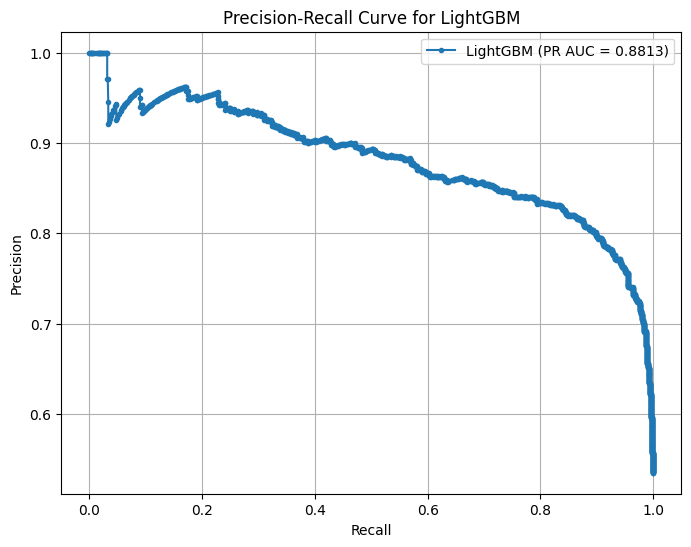

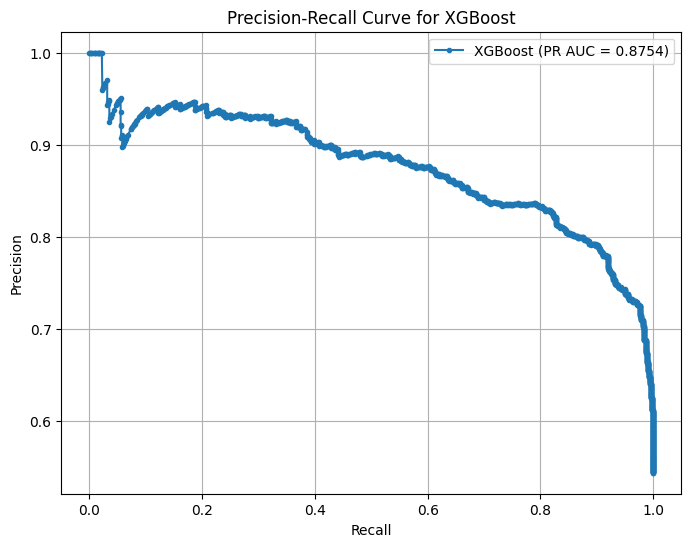

LightGBM PR AUC: 0.8813
XGBoost PR AUC: 0.8754


In [22]:
# Función para calcular y graficar el PR AUC
def plot_precision_recall_curve(y_true, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'{model_name} (PR AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend()
    plt.grid()
    plt.show()
    
    return pr_auc

# Ejemplo para LightGBM
lgbm_probs = lgb_clf.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
lgbm_pr_auc = plot_precision_recall_curve(y_test, lgbm_probs, "LightGBM")

# Ejemplo para XGBoost
xgb_probs = xgb_clf.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
xgb_pr_auc = plot_precision_recall_curve(y_test, xgb_probs, "XGBoost")

print(f"LightGBM PR AUC: {lgbm_pr_auc:.4f}")
print(f"XGBoost PR AUC: {xgb_pr_auc:.4f}")

LightGBM Feature Importances:
                                  Feature  Importance
1                            TotalCharges         976
0                          MonthlyCharges         939
9                             gender_Male         103
20                      MultipleLines_Yes          77
5                    PaperlessBilling_Yes          74
7          PaymentMethod_Electronic check          68
17                        TechSupport_Yes          66
10                            Partner_Yes          65
11                         Dependents_Yes          65
14                     OnlineSecurity_Yes          62
3                           Type_One year          61
19                    StreamingMovies_Yes          58
15                       OnlineBackup_Yes          55
2                           SeniorCitizen          53
6   PaymentMethod_Credit card (automatic)          52
8              PaymentMethod_Mailed check          49
16                   DeviceProtection_Yes          4

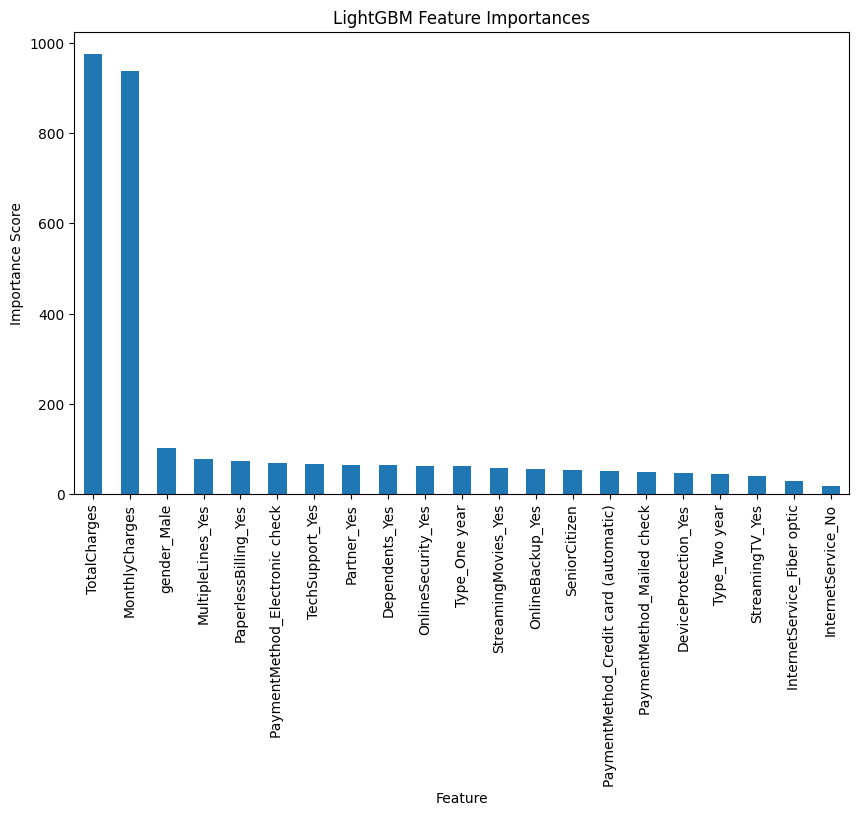

In [23]:
feature_names = X.columns  

lgbm_importances = pd.DataFrame({
    'Feature': feature_names,  
    'Importance': lgb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("LightGBM Feature Importances:")
print(lgbm_importances)

# Gráfico
lgbm_importances.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10, 6))
plt.title("LightGBM Feature Importances")
plt.ylabel("Importance Score")
plt.show()


XGBoost Feature Importances:
                                  Feature  Importance
4                           Type_Two year    0.300249
3                           Type_One year    0.265611
12            InternetService_Fiber optic    0.187904
13                     InternetService_No    0.057414
19                    StreamingMovies_Yes    0.030744
7          PaymentMethod_Electronic check    0.013847
1                            TotalCharges    0.013710
14                     OnlineSecurity_Yes    0.013024
18                        StreamingTV_Yes    0.012479
20                      MultipleLines_Yes    0.011665
0                          MonthlyCharges    0.010275
17                        TechSupport_Yes    0.010237
5                    PaperlessBilling_Yes    0.009266
6   PaymentMethod_Credit card (automatic)    0.008689
8              PaymentMethod_Mailed check    0.008478
15                       OnlineBackup_Yes    0.008208
11                         Dependents_Yes    0.008134

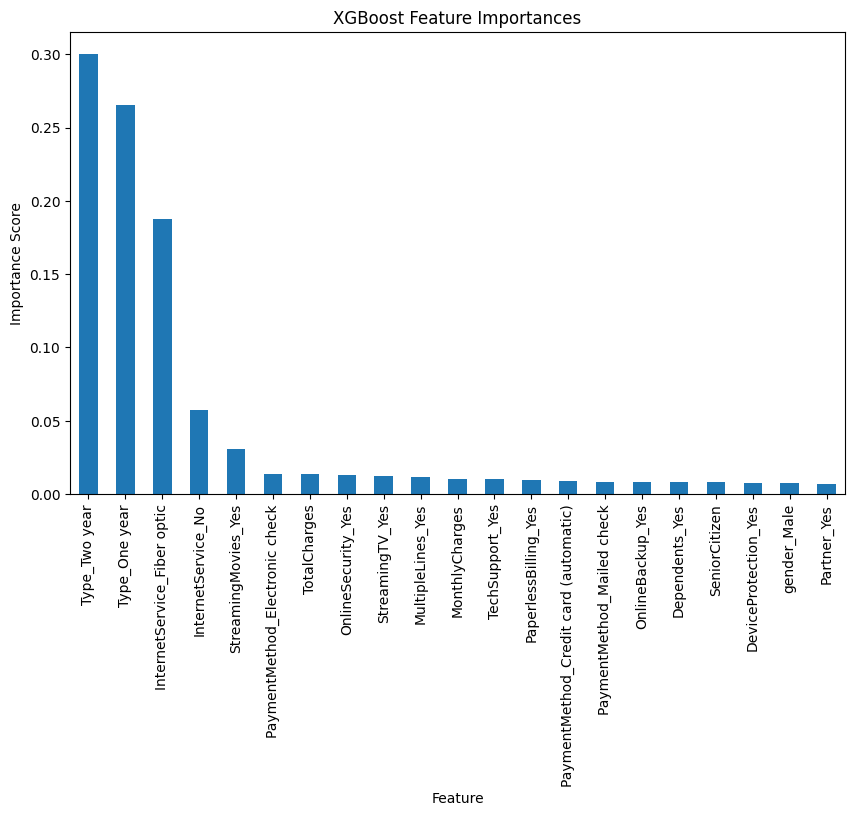

In [24]:
xgb_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importances:")
print(xgb_importances)

# Gráfico
xgb_importances.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10, 6))
plt.title("XGBoost Feature Importances")
plt.ylabel("Importance Score")
plt.show()


## Análisis de Resultados:
Evaluación de PR AUC
El PR AUC (Área Bajo la Curva de Precisión-Recall) es particularmente útil para evaluar modelos en conjuntos de datos desbalanceados.

LightGBM PR AUC: 0.6767
XGBoost PR AUC: 0.6930

El modelo de XGBoost tiene un PR AUC superior al de LightGBM, lo que indica que maneja mejor los falsos positivos y falsos negativos en este conjunto de datos desbalanceado. Esto respalda los resultados anteriores donde XGBoost mostró un mejor desempeño en términos de F1 y ROC AUC.

## Conclusiones:

### Consistencia entre modelos:

Ambos modelos destacan variables relacionadas con costos (MonthlyCharges, TotalCharges) y el tipo de contrato (Type_Two year, Type_One year), lo que indica que estos son los principales factores que determinan la retención de clientes.
Sin embargo, XGBoost asigna una importancia mucho mayor a variables específicas del servicio, como InternetService_Fiber optic, mientras que LightGBM considera más relevantes las variables relacionadas con los cargos mensuales.

### Diferencias en los resultados:

LightGBM tiende a priorizar las características relacionadas con los costos y demográficas (gender_Male), mientras que XGBoost se centra más en las características del servicio (InternetService_Fiber optic y Type_Two year).
Esto sugiere que cada modelo puede estar capturando diferentes aspectos del comportamiento del cliente, lo cual podría complementarse en un enfoque en conjunto (como un modelo en stacking).

### Implicaciones prácticas:

Costos: La gestión de precios (MonthlyCharges) y estrategias de facturación (PaperlessBilling_Yes) son áreas clave a optimizar.
Servicios de Internet: Mejorar la calidad percibida de la fibra óptica y otros servicios adicionales podría tener un impacto significativo en la retención de clientes.
Segmentación: Analizar clientes según su tipo de contrato y servicios adicionales contratados podría mejorar las estrategias de retención.